In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv, DataFrame, Series

/home/yunzhuoz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/yunzhuoz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/yunzhuoz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/yunzhuoz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/yunzhuoz/anaconda3/lib/python3.8/site-packages/sklearn/met

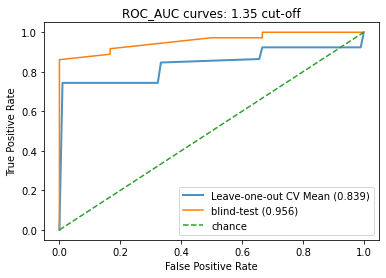

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, matthews_corrcoef, f1_score
from matplotlib import pyplot
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold

training_set=read_csv('filtered_train.csv')

training_ID = pd.DataFrame(training_set['ID'])
training_set = training_set.drop('ID', axis=1)

train_group = np.array(training_set['group'])
training_set = training_set.drop('group', axis=1)

train_label = np.array(training_set['Phenotype'])
training_features = training_set.drop('Phenotype', axis=1)

########################################################################
le = preprocessing.LabelEncoder()
le.fit(train_label)
train_label = le.transform(train_label)
headers = list(training_features.columns.values)

cv_metrics = pd.DataFrame()

# 10-fold cross validation
predicted_n_actual_pd = pd.DataFrame(columns=['chembl', 'predicted', 'actual', 'fold','prob'])
kf = GroupKFold(n_splits=14)
fold = 1 # for indexing
mean_fpr = np.linspace(0, 1, 100)
tprs = []
#aucs = []
############################################################################
for train, test in kf.split(training_features, train_label, train_group):
        # train and test number(row number) are based on training_features.
        # For example, if '1' from train or test, it would be '1' in training_features

    train_cv_features, test_cv_features, train_cv_label, test_cv_label = training_features.iloc[train], \
                                                                             training_features.iloc[test], train_label[
                                                                                 train], train_label[test]

        
    temp_classifier = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=16)

    temp_classifier.fit(train_cv_features, train_cv_label)
    temp_prediction = temp_classifier.predict(test_cv_features)
    # predict probabilities
    lr_probs = temp_classifier.predict_proba(test_cv_features)
    lr_probs = lr_probs[:, 1]
    ns_probs = [0 for _ in range(len(test_cv_label))]

    # calculate scores
    #ns_auc = roc_auc_score(test_cv_label, ns_probs)
    #lr_auc = roc_auc_score(test_cv_label, lr_probs)
    # summarize scores
    #print('No Skill: ROC AUC=%.3f' % (ns_auc))
    #print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_cv_label, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(test_cv_label, lr_probs)
    # plot the roc curve for the model
    
    #pyplot.plot(lr_fpr, lr_tpr, label='Logistic')
    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    #aucs.append(viz.roc_auc)

    predicted_n_actual_pd = predicted_n_actual_pd.append(pd.DataFrame({'prob':lr_probs,'chembl':test, 'actual':test_cv_label, 'predicted' : temp_prediction, 'fold':fold}),ignore_index=True, sort=True)
    fold += 1
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
########################################
#A[~np.isnan(A)].mean()
mean_tpr = np.nanmean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#std_auc = np.std(aucs)
pyplot.plot(mean_fpr, mean_tpr,
        label=r'Leave-one-out CV Mean (%0.3f)'% (mean_auc),
        lw=2, alpha=.8)
####################################
    # axis labels
outerblind_set=read_csv('filtered_test.csv')
outerblind_set_ID = pd.DataFrame(outerblind_set['ID'])
outerblind_label = np.array(outerblind_set['Phenotype'])
outerblind_features = outerblind_set[headers]
outerblind_label = le.transform(outerblind_label)
temp_classifier = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=16)
temp_classifier.fit(training_features,train_label)
prediction = temp_classifier.predict(outerblind_features)

lr_probs = temp_classifier.predict_proba(outerblind_features)
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(outerblind_label))]

    # calculate scores
#ns_auc = roc_auc_score(outerblind_label, ns_probs)
lr_auc = roc_auc_score(outerblind_label, lr_probs)
    # summarize scores
#print('No Skill: ROC AUC=%.2f' % (ns_auc))
#print('Logistic: ROC AUC=%.2f' % (lr_auc))
    # calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(outerblind_label, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(outerblind_label, lr_probs)
    # plot the roc curve for the model

pyplot.plot(lr_fpr, lr_tpr, label=r'blind-test (%0.3f)'% (lr_auc),)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--',label='chance')
    # axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC_AUC curves: 1.35 cut-off')
    # show the legend
pyplot.legend()
    # show the plot
pyplot.show()

In [28]:
print(round(matthews_corrcoef(predicted_n_actual_pd['actual'].to_list(),predicted_n_actual_pd['predicted'].to_list()),3))
print(round(matthews_corrcoef(outerblind_label, prediction),3))

0.731
0.685


In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

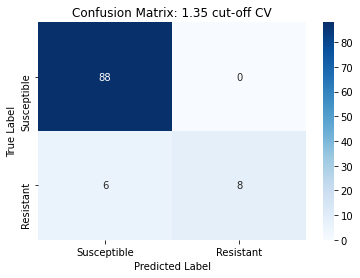

In [41]:
labels = read_csv('cv_RF_predited_data.csv')
y = labels['actual'].to_list()
y_pred = labels['predicted'].to_list()
classes = ['Susceptible', 'Resistant']
df = pd.DataFrame(confusion_matrix(y, y_pred, labels=classes), index=classes, columns=classes)
sns.heatmap(df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: 1.35 cut-off CV")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.yticks(rotation=90)
plt.show()

In [37]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y, y_pred)

0.7314057747207311

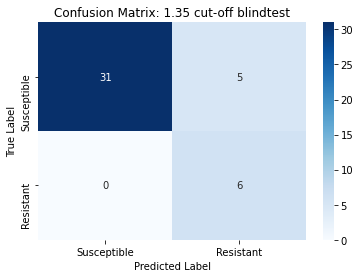

In [40]:
labels = read_csv('blindtest_RF_predicted_data.csv')
y = labels['actual'].to_list()
y_pred = labels['predicted'].to_list()
classes = ['Susceptible', 'Resistant']
df = pd.DataFrame(confusion_matrix(y, y_pred, labels=classes), index=classes, columns=classes)
sns.heatmap(df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: 1.35 cut-off blindtest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.yticks(rotation=90)
plt.show()

In [39]:
matthews_corrcoef(y, y_pred)

0.6853444168423418

In [3]:
from sklearn.metrics import matthews_corrcoef
labels = read_csv('train_scatter_plot.csv')
y = labels['actual'].to_list()
y_pred = labels['predicted'].to_list()
matthews_corrcoef(y, y_pred)

0.6405595802215259

In [5]:
labels = read_csv('blind_scatter_plot.csv')
y = labels['actual'].to_list()
y_pred = labels['predicted'].to_list()
matthews_corrcoef(y, y_pred)

0.5724020451068287

In [4]:
labels = read_csv('benchmark_pred_merge.csv')
y = labels['actual'].to_list()
y_pred = labels['predicted'].to_list()
matthews_corrcoef(y, y_pred)

0.4131480722670183

In [3]:
from sklearn.metrics import matthews_corrcoef
labels = read_csv('reg_train_pred.csv')
y = labels['actual'].to_list()
y_pred = labels['trans_predicted'].to_list()
matthews_corrcoef(y, y_pred)

0.5247304294471912

In [5]:
labels = read_csv('reg_blind_pred.csv')
y = labels['actual'].to_list()
y_pred = labels['trans_predicted'].to_list()
matthews_corrcoef(y, y_pred)

-0.10758287072798381